# **Title: Analysing Housing Satisfaction in the Netherlands 🇳🇱: Data-Driven Insights for Urban Policy and Development (CBS StatLine Dataset)**
- **Nederlands**: "Wat maakt Nederlanders tevreden over hun woning? In dit project analyseren we gegevens van het CBS om te ontdekken welke factoren bijdragen aan woontevredenheid."
- **English:** "What makes Dutch residents happy with their homes? In this project, we analyse CBS data to uncover factors driving housing satisfaction."

## What Is the CBS API?

The CBS API (from Centraal Bureau voor de Statistiek) is a web-based interface that allows us to programmatically access datasets published on the CBS StatLine platform. Instead of manually downloading CSV or Excel files, we may write code in Python that automatically pulls live data from CBS servers.

**Data Link:**
https://opendata.cbs.nl/statline/portal.html?_la=en&_catalog=CBS&tableId=84571ENG&_theme=1168

**API Link:**
https://opendata.cbs.nl/ODataApi/odata/84571ENG

## Methodologie (English: Methodology)

------

#### **1) Nederlands**

Dit notebook analyseert de woonsatisfactie in Nederland met behulp van open overheidsdata van het CBS (Centraal Bureau voor de Statistiek).

(a) **Methode 1: 'requests' + 'json_normalize'**
- Werken met een open API en ruwe JSON-data verwerken. Dit is handig wanneer je werkt met API’s zonder bestaande wrappers.
- **Zonder** wrapper: We halen handmatig gegevens op via URL’s, parseren de JSON-data zelf en doorlopen de paginering handmatig.

(b) **Methode 2: 'cbsodata' Python-package**
- De 'cbsodata'-package is een specifiek Nederlands hulpmiddel dat het werken met grote datasets vereenvoudigt door automatisch paginering en metadata af te handelen.
- **Met** wrapper: We hoeven alleen cbsodata.get_data("84571ENG") aan te roepen, en alles gebeurt automatisch (requests, paginering en parsing).

----

#### **2) English**

This notebook analyses housing satisfaction in the Netherlands using open government data from CBS (Centraal Bureau voor de Statistiek).

(a) **Method 1: 'requests' + 'json_normalize'**

- Work with open API and handle raw JSON data. It is useful when working with APIs that do not have wrappers.
- **Without** wrapper: We manually fetch data from URLs, handle JSON parsing, and loop over pages.

(b) **Method 2: 'cbsodata' Python package**

- The 'cbsodata' is a Netherlands-specific tool which simplifies working with large datasets by handling pagination and metadata automatically.
- **With** wrapper: We just call cbsodata.get_data("84571ENG") and it does everything automatically (requests, pagination, and parsing).



## **Import Libraries**

In [1]:
# Load full dataset using CBS wrapper (handles pagination automatically)

!pip install cbsodata --upgrade --quiet

In [2]:
# Import necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid")

import requests

import cbsodata

import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

from google.colab import files
import joblib

####  Method 1: Preview Data Using Raw API (OData + JSON)

We first make a direct 'GET' request to the CBS OData API to fetch a small subset ('$top=10') of the '84571ENG' dataset. Then use 'json_normalize' and convert the nested JSON structure into a flat Pandas DataFrame for inspection.

In [3]:
# import requests

# Try getting a small slice of the data using raw API and json

url = 'https://opendata.cbs.nl/ODataApi/odata/84571ENG/TypedDataSet?$top=10'  # only 10 rows for preview

response = requests.get(url)
data = response.json()

# Normalize the JSON response into a flat table

df_preview = pd.json_normalize(data['value'])

# Preview the data

print('Preview Shape:', df_preview.shape)
df_preview.head(5)

Preview Shape: (10, 8)


,ID,OwnerTenant,DwellingCharacteristics,Margins,Regions,Periods,SatisfactionWithCurrentDwelling_1,SatisfactionWithLivingEnvironment_2
0,0,T001096,T001100,MW00000,NL01,2002JJ00,89.2,84.3
1,1,T001096,T001100,MW00000,NL01,2006JJ00,89.7,85.0
2,2,T001096,T001100,MW00000,NL01,2009JJ00,90.0,83.4
3,3,T001096,T001100,MW00000,NL01,2012JJ00,89.0,84.1
4,4,T001096,T001100,MW00000,NL01,2015JJ00,86.9,82.0


#### Method 2: Load Full Dataset Using 'cbsodata'

After previewing the dataset manually, we use the 'cbsodata' library to fetch the complete Housing Satisfaction dataset. This library is widely used in the Netherlands for working with CBS StatLine data and handles pagination and API structure internally.


In [4]:
# Load full dataset using CBS wrapper (handles pagination automatically)
# Install the cbsodata

# !pip install cbsodata --upgrade --quiet

In [5]:
# import cbsodata

df = pd.DataFrame(cbsodata.get_data('84571ENG'))

# Check the size

print('Shape of the Dataset:', df.shape)
df.head(5)

Shape of the Dataset: (295680, 8)


,ID,OwnerTenant,DwellingCharacteristics,Margins,Regions,Periods,SatisfactionWithCurrentDwelling_1,SatisfactionWithLivingEnvironment_2
0,0,Total,Total dwellings,Value,The Netherlands,2002,89.2,84.3
1,1,Total,Total dwellings,Value,The Netherlands,2006,89.7,85.0
2,2,Total,Total dwellings,Value,The Netherlands,2009,90.0,83.4
3,3,Total,Total dwellings,Value,The Netherlands,2012,89.0,84.1
4,4,Total,Total dwellings,Value,The Netherlands,2015,86.9,82.0


## **Understand the Dataset**

#### 1) Analyse the Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295680 entries, 0 to 295679
Data columns (total 8 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ID                                   295680 non-null  int64  
 1   OwnerTenant                          295680 non-null  object 
 2   DwellingCharacteristics              295680 non-null  object 
 3   Margins                              295680 non-null  object 
 4   Regions                              295680 non-null  object 
 5   Periods                              295680 non-null  object 
 6   SatisfactionWithCurrentDwelling_1    184539 non-null  float64
 7   SatisfactionWithLivingEnvironment_2  184539 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 18.0+ MB


#### 2) Create a Deep Copy of the DataFrame

In [7]:
df1 = df.copy(deep = True)

#### 3) Identify the Target Variable

In [8]:
# List the features

df.columns.tolist()

['ID',
 'OwnerTenant',
 'DwellingCharacteristics',
 'Margins',
 'Regions',
 'Periods',
 'SatisfactionWithCurrentDwelling_1',
 'SatisfactionWithLivingEnvironment_2']

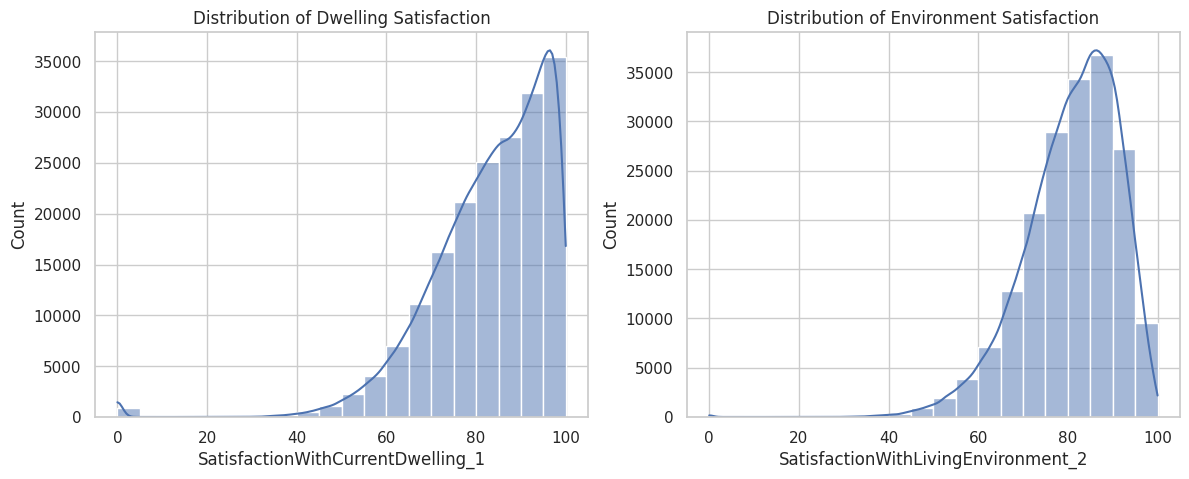

In [9]:
# We may have to decide between the following two features:

# 1) House: Satisfaction with the house itself, housing policy, affordability, housing type, design, etc.
# 2) Environment: Satisfaction with the locality, neighbourhood, parks, noise, safety, etc.

fig, axes = plt.subplots(1, 2, figsize = (14, 5))

sns.histplot(df1['SatisfactionWithCurrentDwelling_1'], bins = 20, kde = True, ax = axes[0])
axes[0].set_title('Distribution of Dwelling Satisfaction')

sns.histplot(df1['SatisfactionWithLivingEnvironment_2'], bins = 20, kde = True, ax = axes[1])
axes[1].set_title('Distribution of Environment Satisfaction')

plt.show()

## Observaties (English: Observations)

----

#### 1) **Nederlands**
- De meeste mensen zijn tevreden met hun woning en leefomgeving.
- Rechts-scheef: De meerderheid van de mensen beoordeelt hun tevredenheid over hun woning en omgeving hoog (80–100).
- Lage ontevredenheidsstaart: Een merkbare maar kleine linkerstaart geeft aan dat een minderheid sterk ontevreden is.

----

#### 2) **English**
- Most people are satisfied with their dwelling and environment.
- Right-skewed: Majority of people score their dwelling and environment satisfaction highly (80–100).
- Low dissatisfaction tail: A noticeable but small left tail indicates a minority are highly dissatisfied.

In [10]:
# We have decided to use 'SatisfactionWithCurrentDwelling_1' as our target variable.
# This will help us detect the tenant's satisfaction with their own home.

target_variable = df1['SatisfactionWithCurrentDwelling_1']

#### 4) Check for Null Values

In [11]:
print('Total null values:', df1.isnull().sum().sum())

Total null values: 222282


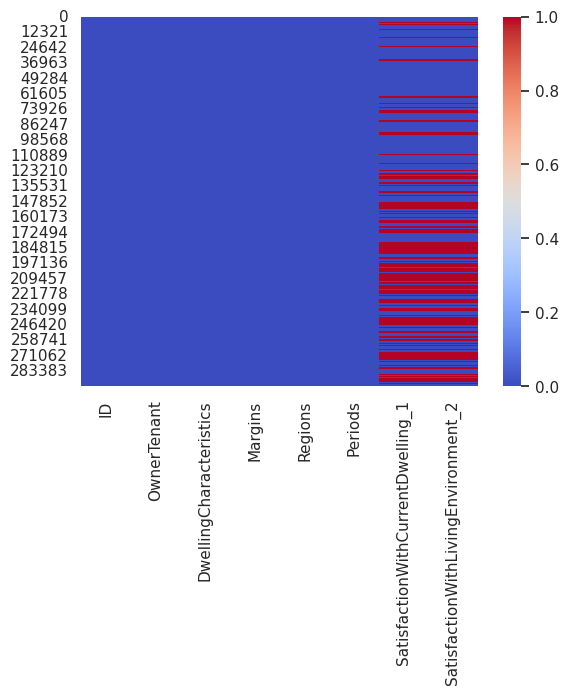

In [12]:
sns.heatmap(df1.isnull(), cmap = 'coolwarm', cbar = True)
plt.show()

#### 5) Check for Imputation or Drop

In [13]:
# Drop null values for 'SatisfactionWithCurrentDwelling_1' and 'SatisfactionWithLivingEnvironment_2'

df1 = df1.dropna(subset = ['SatisfactionWithCurrentDwelling_1', 'SatisfactionWithLivingEnvironment_2'])

In [14]:
print('Total null values:', df1.isnull().sum().sum())

Total null values: 0


In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184539 entries, 0 to 295679
Data columns (total 8 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ID                                   184539 non-null  int64  
 1   OwnerTenant                          184539 non-null  object 
 2   DwellingCharacteristics              184539 non-null  object 
 3   Margins                              184539 non-null  object 
 4   Regions                              184539 non-null  object 
 5   Periods                              184539 non-null  object 
 6   SatisfactionWithCurrentDwelling_1    184539 non-null  float64
 7   SatisfactionWithLivingEnvironment_2  184539 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 12.7+ MB


#### 6) Check for Duplicates

In [16]:
duplicates = df1.duplicated()
print(duplicates, end = '\n\n')
print(f'Total number of duplicate entries: {duplicates.sum()}')

0         False
1         False
2         False
3         False
4         False
          ...  
295674    False
295675    False
295677    False
295678    False
295679    False
Length: 184539, dtype: bool

Total number of duplicate entries: 0


#### 7) Check for Unique Values

In [17]:
# Check for unique values

for i in df1.columns:
  print('Number of Unique Values in ', i, 'is', df1[i].nunique())

Number of Unique Values in  ID is 184539
Number of Unique Values in  OwnerTenant is 5
Number of Unique Values in  DwellingCharacteristics is 28
Number of Unique Values in  Margins is 3
Number of Unique Values in  Regions is 88
Number of Unique Values in  Periods is 8
Number of Unique Values in  SatisfactionWithCurrentDwelling_1 is 703
Number of Unique Values in  SatisfactionWithLivingEnvironment_2 is 679


In [18]:
# List of columns to exclude while printing unique values to check which encoding to use (one-hot or label)

exclude_cols = ['ID', 'Regions', 'SatisfactionWithCurrentDwelling_1', 'SatisfactionWithLivingEnvironment_2']

# Print unique values (excluding the features above)

for j in df1.columns:
    if j not in exclude_cols:
        print(f"Unique values in '{j}':")
        print(df1[j].unique())
        print('---')

Unique values in 'OwnerTenant':
['Total' 'Owner' 'Tenant' 'Rents dwelling from private owner'
 'Rents dwelling from housing corporation']
---
Unique values in 'DwellingCharacteristics':
['Total dwellings' 'Type of dwelling: single-family; total'
 'Type of dwelling: detached house'
 'Type of dwelling: semi-detached house' 'Type of dwelling: corner house'
 'Type of dwelling: terraced house' 'Type of dwelling: multi-family'
 'Living surface: less than  75 m²' 'Living surface: 75 to 99 m²'
 'Living surface: 100 to 149 m²' 'Living surface: 150 m² or more'
 'Number of rooms: 2 or less' 'Number of rooms: 3' 'Number of rooms: 4'
 'Number of rooms: 5' 'Number of rooms: 6' 'Number of rooms: 7 or more'
 'Year of construction: 1000 to 1945' 'Year of construction: 1946 to 1970'
 'Year of construction: 1971 to 1985' 'Year of construction: 1986 to 2000'
 'Year of construction: from 2001' 'Dwelling: 1st 25%-group WOZ'
 'Dwelling: 2nd 25%-group WOZ' 'Dwellings: 3rd 25%-group WOZ'
 'Dwellings: 4th 25%-g

#### 8) Statistical Summary

In [20]:
df1.describe().style.background_gradient(cmap = 'coolwarm')

,ID,SatisfactionWithCurrentDwelling_1,SatisfactionWithLivingEnvironment_2
count,184539.000000,184539.000000,184539.000000
mean,125212.349438,83.094064,80.830481
std,86068.701949,13.258492,10.443222
min,0.000000,0.000000,0.000000
25%,52453.500000,75.700000,74.600000
50%,111124.000000,85.400000,82.300000
75%,190117.500000,93.400000,88.600000
max,295679.000000,100.000000,100.000000


## **Exploratory Data Analysis (EDA)**

#### 1) Check for Outliers

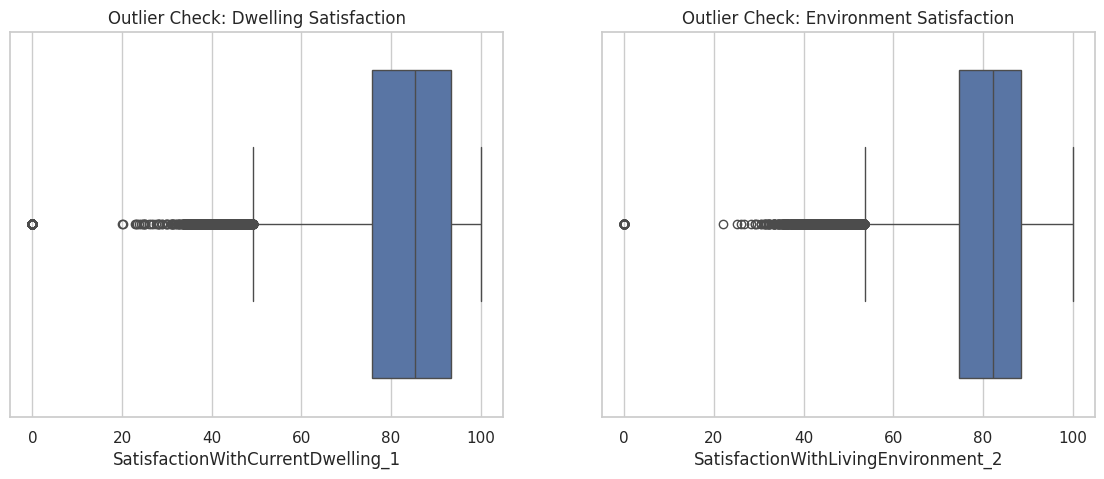

In [21]:
# Dwelling satisfaction

fig, axes = plt.subplots(1, 2, figsize = (14, 5))
sns.boxplot(x = df1['SatisfactionWithCurrentDwelling_1'], ax = axes[0])
axes[0].set_title("Outlier Check: Dwelling Satisfaction")

# Living environment satisfaction

sns.boxplot(x = df1['SatisfactionWithLivingEnvironment_2'], ax = axes[1])
axes[1].set_title("Outlier Check: Environment Satisfaction")

plt.show()

## Observaties (English: Observations)

----

#### **1) Nederlands**
##### (a) **Visuele Analyse**
- De meeste bewoners zijn zeer tevreden.
- De mediaan ligt boven de 70.

##### (b) **Uitzonderingen**
- Een significant aantal uitzonderingen ligt onder de 50.
- Dit suggereert een kleine groep sterk ontevreden bewoners.

##### (c) **Spreiding**
- De IQR is smal en scheef naar de hogere waarden.
- De meeste mensen zijn erg gelukkig, maar de ontevreden bewoners hebben aandacht nodig.

----

#### **2) English**
##### (a) **Visual Analysis**
- Most residents are highly satisfied.
- Median is above 70.

##### (b) **Outliers**
- A significant number of outliers below 50.
- This suggests a small group of highly dissatisfied residents.

##### (c) **Spread**
- IQR is narrow and skewed to the high end.
- Most people are very happy, but the unhappy residents need attention.

#### 2) Check Happiness Level

In [22]:
# To detemine the happiness level we need to determine a threshold value
# We are selecting 70 as the threshold for people who can be considered happy

unhappy_house = (df1['SatisfactionWithCurrentDwelling_1'] < 70).sum()
unhappy_env = (df1['SatisfactionWithLivingEnvironment_2'] < 70).sum()

print("Count of People Unhappy with House:", unhappy_house)
print("Count of People Unhappy with Environment:", unhappy_env)

Count of People Unhappy with House: 27089
Count of People Unhappy with Environment: 27116


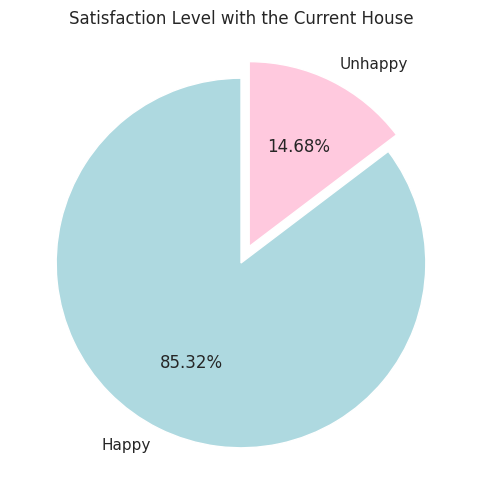

In [23]:
# Visualising a Pie chart for Satisfaction Level with the Current House

colors = ['#AED9E0', '#FFC9DE']

target_counts = (df1['SatisfactionWithCurrentDwelling_1'] < 70).value_counts()

plt.figure(figsize = (6, 6))
target_counts.plot.pie(autopct = '%1.2f%%', startangle = 90, colors = colors, explode = [0, 0.1], labels = ['Happy', 'Unhappy'])

plt.title('Satisfaction Level with the Current House')
plt.ylabel('')
plt.show()

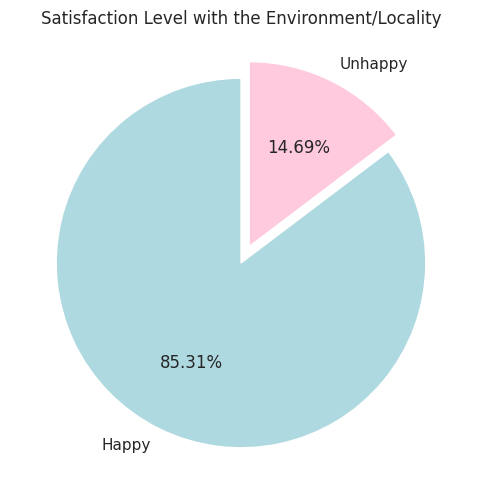

In [24]:
# Visualising a Pie chart for Satisfaction Level with the Environment/Locality

colors = ['#AED9E0', '#FFC9DE']

target_counts = (df1['SatisfactionWithLivingEnvironment_2'] < 70).value_counts()

plt.figure(figsize = (6, 6))
target_counts.plot.pie(autopct = '%1.2f%%', startangle = 90, colors = colors, explode = [0, 0.1], labels = ['Happy', 'Unhappy'])

plt.title('Satisfaction Level with the Environment/Locality')
plt.ylabel('')
plt.show()

## Observaties (English: Observations)

----

#### **1) Nederlands**
##### Ontevreden Bewoners:
- Ongeveer 15% van de huurders is ontevreden over hun huidige woning en leefomgeving.
- Het percentage mensen dat ontevreden is over de woning (14,68%) en de omgeving (14,69%) is bijna identiek.
- Hoewel het aantal ontevreden huurders relatief laag is, is hun feedback cruciaal voor het begrijpen van welke woning- of omgevingsfactoren mogelijk onderpresteren.

----

#### **2) English**
##### Unhappy Residents:
- Around 15% of tenants are dissatisfied with their current house and living environment.
- The proportion of people dissatisfied with the house (14.68%) and the environment (14.69%) is nearly identical.
- Although the number of unhappy tenants is relatively low, their feedback is crucial to understanding which housing or environmental factors may be underperforming.

#### 3) Label the Target Variable
- While also labelling another feature to see if the people who are unhappy with their houses, are they also unhappy with their enviroment. We may analyse if the locality has anything to do with the house satisfaction.

In [25]:
df1['Dwelling_Satisfied'] = df1['SatisfactionWithCurrentDwelling_1'].apply(lambda x: 1 if x >= 70 else 0)
df1['Environment_Satisfied'] = df1['SatisfactionWithLivingEnvironment_2'].apply(lambda x: 1 if x >= 70 else 0)

#### 4) Feature Distribution

In [26]:
numerical_features = []
categorical_features = []

for i in df.columns:
  if df[i].dtype in ['int64', 'float64']:
    numerical_features.append(i)
  else:
    categorical_features.append(i)

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['ID', 'SatisfactionWithCurrentDwelling_1', 'SatisfactionWithLivingEnvironment_2']
Categorical Features: ['OwnerTenant', 'DwellingCharacteristics', 'Margins', 'Regions', 'Periods']


#### 5) Correlation and Visualisation


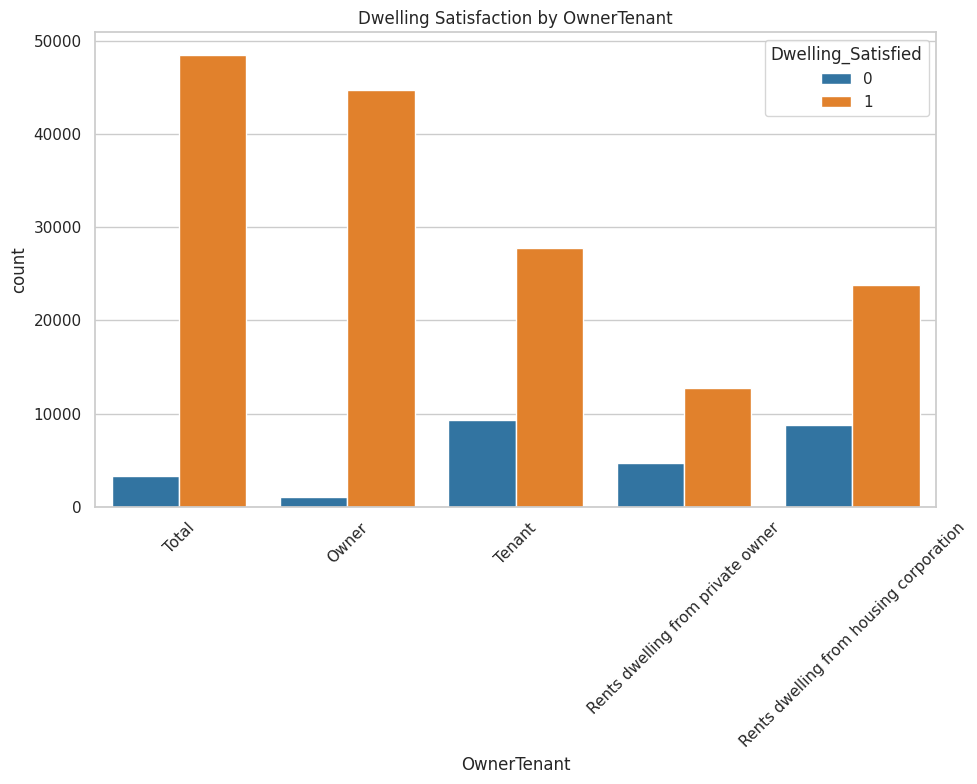

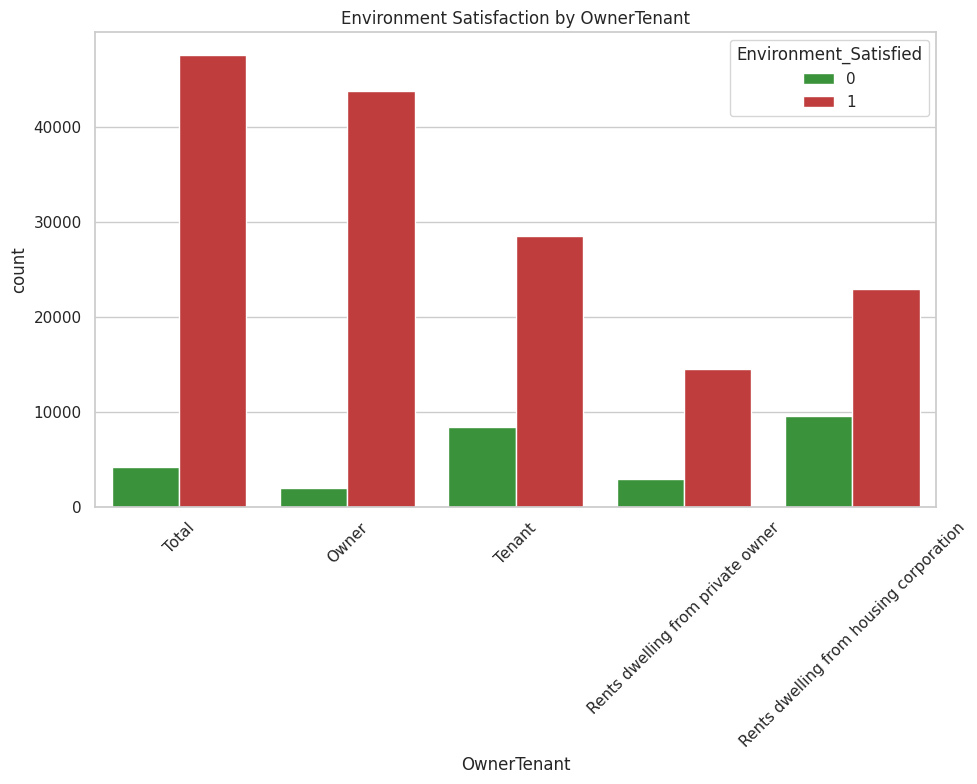

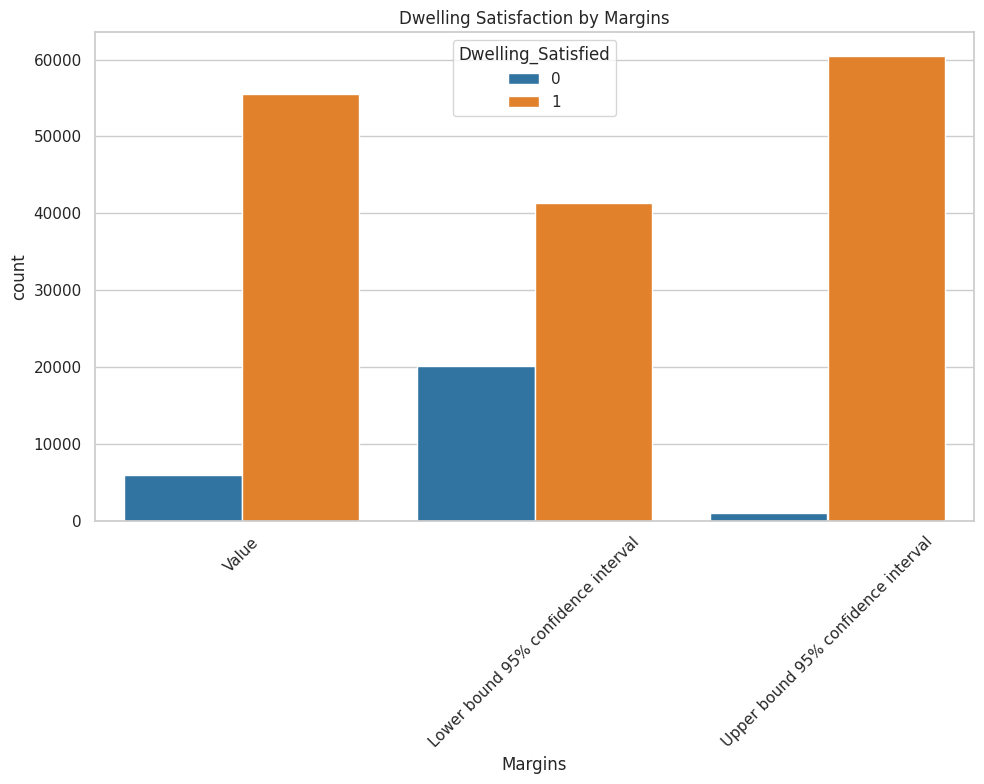

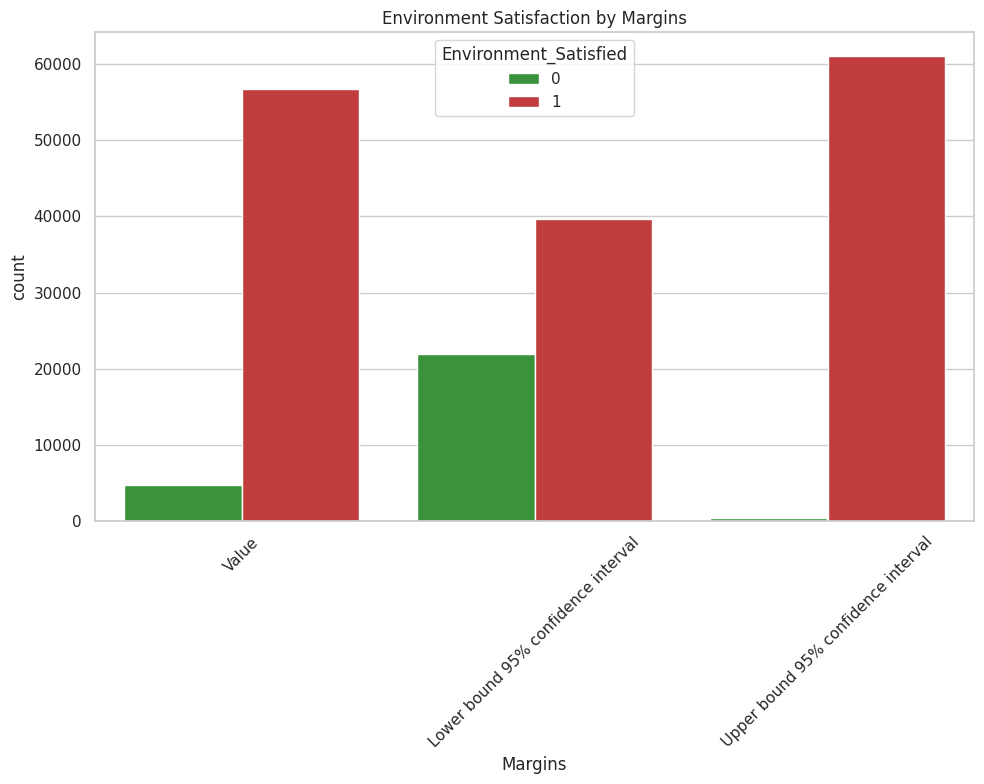

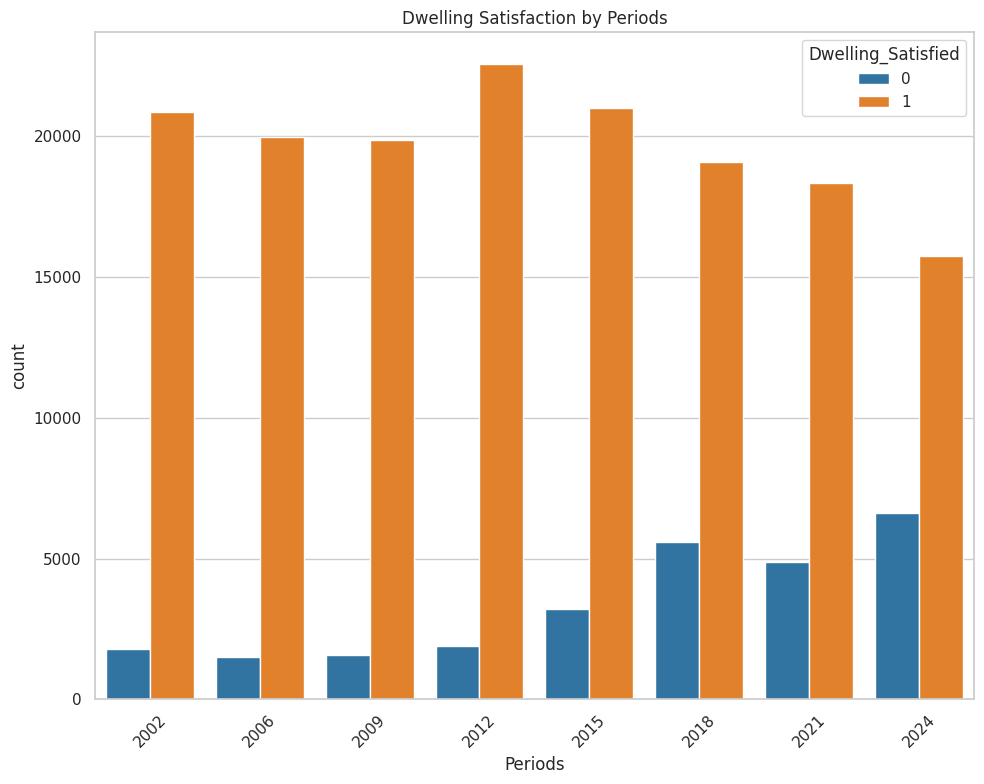

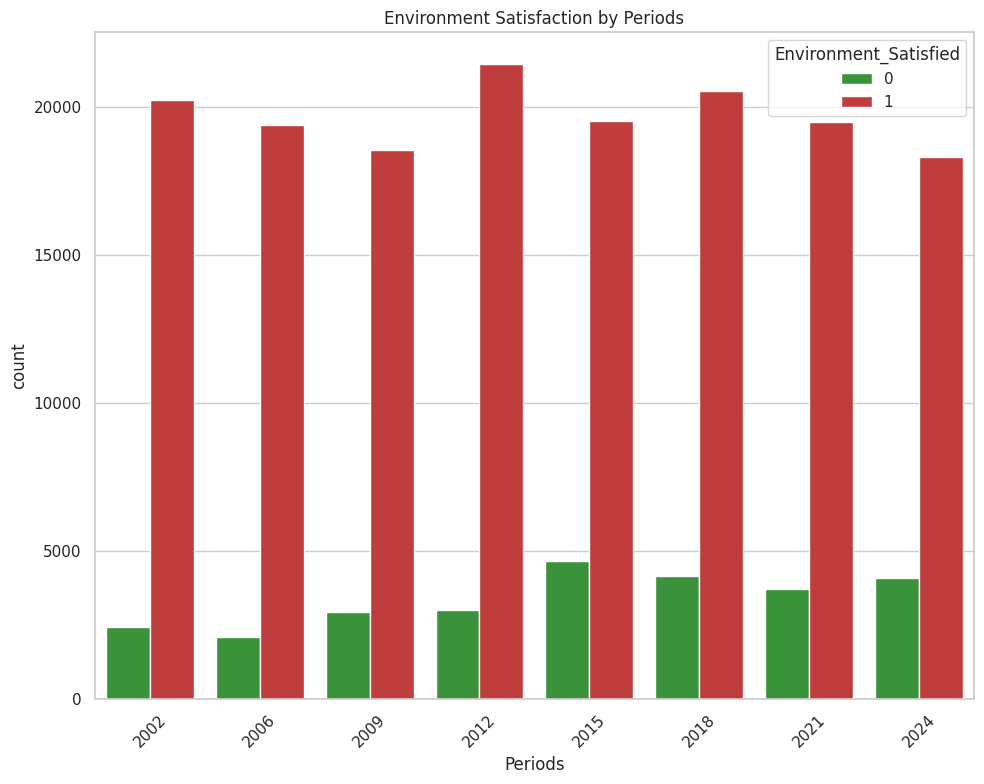

In [27]:
# Compare dwelling satisfaction
# And, compare environment satisfaction

for i in ['OwnerTenant', 'Margins', 'Periods']:

  plt.figure(figsize = (10, 8))
  sns.countplot(x = i, hue = 'Dwelling_Satisfied', data = df1, palette = ['#1f77b4', '#ff7f0e'])
  plt.title(f'Dwelling Satisfaction by {i}')
  plt.xticks(rotation = 45)
  plt.tight_layout()
  plt.show()

  plt.figure(figsize = (10, 8))
  sns.countplot(x = i, hue = 'Environment_Satisfied', data = df1, palette = ['#2ca02c', '#d62728'])
  plt.title(f'Environment Satisfaction by {i}')
  plt.xticks(rotation = 45)
  plt.tight_layout()
  plt.show()

## Observaties voor de Ongelukkige Bewoners (English: Observations for the Unhappy Residents)

----

#### **1) Nederlands**
##### (a) **Ontevreden Bewoners per Periode**
- Huurders (vooral degenen die huren van woningcorporaties of particuliere eigenaren) vormen de meerderheid van de ontevreden bewoners.
- Huiseigenaren melden de minste ontevredenheid.

##### (b) **Ontevreden Bewoners per Eigendomstype**
- Stijgende Ontevredenheid in de Afgelopen Jaren: Een duidelijke opwaartse trend is zichtbaar: ontevredenheid stijgt dramatisch van 2015 tot 2024. Dit zou de groeiende woningdruk, betaalbaarheidscrises of verstedelijkingsproblemen in Nederland kunnen weerspiegelen.
- Oudere Periodes Tonen Minder Ontevreden Bewoners: 2002–2012 had consistent lagere aantallen van ontevredenheid. Mogelijke redenen: Werkelijk betere omstandigheden in die tijd, veranderende verwachtingen (bewoners verwachten nu meer), of verschillen in steekproefomvang in de enquêtejaren.

----

#### **2) English**
##### (a) **Unhappy Residents by Ownership Type**
- Tenants (especially those renting from housing corporations or private owners) form the majority of unhappy residents.
- Homeowners report the least dissatisfaction.

##### (b) **Unhappy Residents by Periods**
- Rising Dissatisfaction in Recent Years: A clear upward trend is visible: dissatisfaction rises dramatically from 2015 to 2024. This could reflect growing housing pressure, affordability crises, or urbanization issues in the Netherlands.
- Older Periods Show Fewer Unhappy Residents: 2002–2012 had consistently lower numbers of dissatisfaction. Possible reasons: Actual better conditions at the time, changing expectations (residents now expect more), or sampling size differences in survey years.

In [28]:
# import plotly.express as px

In [29]:
# House/Dwelling Satisfaction vs Regions

# Aggregate satisfaction rates by Region

dwelling_summary = (df1.groupby('Regions').agg(count = ('Dwelling_Satisfied', 'count'),
                                             satisfaction_rate = ('Dwelling_Satisfied', 'mean')).reset_index())

# Create a Treemap

fig = px.treemap(dwelling_summary,
                 path = ['Regions'],
                 values = 'count',  # area size by count
                 color = 'satisfaction_rate',  # color intensity by satisfaction
                 color_continuous_scale = 'RdYlGn',
                 title = 'Dwelling Satisfaction Rate by Region (Treemap)',
                 labels = {'satisfaction_rate': 'Satisfaction Rate'})
fig.show()

In [30]:
# Environment/Locality Satisfaction vs Regions

# Aggregate satisfaction rates by Region

environment_summary = (df1.groupby('Regions').agg(count = ('Environment_Satisfied', 'count'),
                                             satisfaction_rate = ('Environment_Satisfied', 'mean')).reset_index())

# Create a Treemap

fig = px.treemap(environment_summary,
                 path = ['Regions'],
                 values = 'count',  # area size by count
                 color = 'satisfaction_rate',  # color intensity by satisfaction
                 color_continuous_scale = 'RdYlGn',
                 title = 'Environment Satisfaction Rate by Region (Treemap)',
                 labels = {'satisfaction_rate': 'Satisfaction Rate'})
fig.show()

/tmp/ipython-input-31-4049810841.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




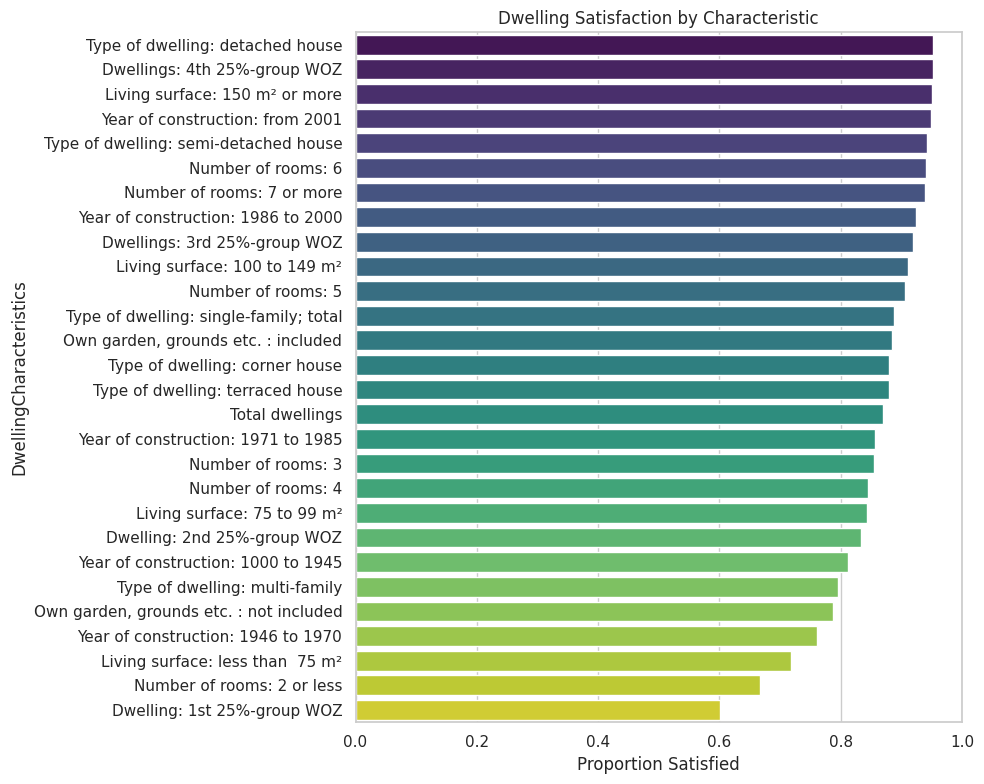

In [31]:
# House/Dwelling Satisfaction vs Dwelling Characteristics

summary = df1.groupby('DwellingCharacteristics')['Dwelling_Satisfied'].mean().sort_values(ascending = False).reset_index()

plt.figure(figsize = (10,8))
sns.barplot(data = summary, y = 'DwellingCharacteristics', x = 'Dwelling_Satisfied', palette = 'viridis')
plt.xlabel('Proportion Satisfied')
plt.title('Dwelling Satisfaction by Characteristic')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

/tmp/ipython-input-32-4129210169.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




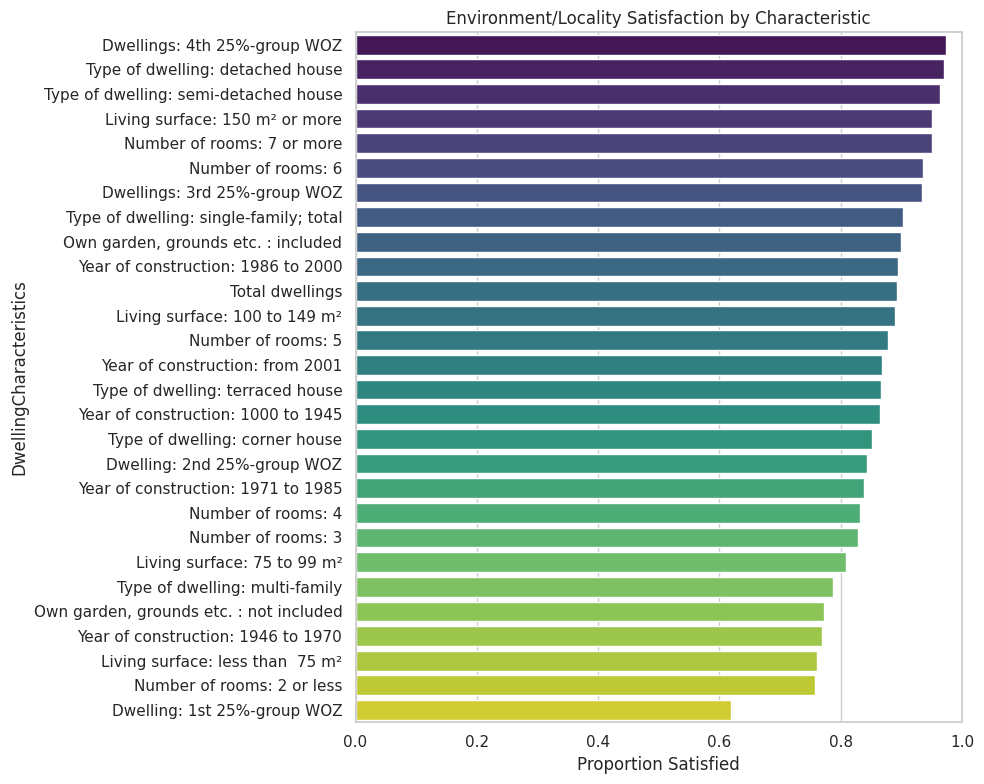

In [32]:
# Environment/Locality Satisfaction vs Dwelling Characteristics

summary = df1.groupby('DwellingCharacteristics')['Environment_Satisfied'].mean().sort_values(ascending = False).reset_index()

plt.figure(figsize = (10,8))
sns.barplot(data = summary, y = 'DwellingCharacteristics', x = 'Environment_Satisfied', palette = 'viridis')
plt.xlabel('Proportion Satisfied')
plt.title('Environment/Locality Satisfaction by Characteristic')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

## Observaties voor de Ongelukkige Bewoners (English: Observations for the Unhappy Residents)

----

#### **1) Nederlands**
##### **Ontevreden Bewoners per Woningkenmerken**
- Kleinere Woonruimtes zijn een Belangrijke Factor: De hoogste categorie is "Woonoppervlakte: minder dan 75 m²", wat aangeeft dat kleinere woningen sterk correleren met ontevredenheid.
- Lage Vastgoedwaarde: "Woning: 1e 25%-groep WOZ" betekent dat dit de laagste vastgoedwaarde-groeperingen zijn, wat suggereert dat financiële of kwaliteitsbeperkingen ontevredenheid kunnen veroorzaken.
- Oude Bouw: Woningen gebouwd tussen 1946–1970 en zelfs 1000–1945 (voor de oorlog) komen vaak voor bij de ontevreden bewoners, wat wijst op verouderd woningaanbod als een zorg.
- Geen Buitenruimte: De eigenschap "Eigen tuin, terrein enz.: niet inbegrepen" staat hoog op de lijst, wat suggereert dat het gebrek aan groen/buitenruimte bijdraagt aan ontevredenheid.
- Meergezinswoningen & Beperkt Aantal Kamers: “Woningtype: meergezinswoning” en kleinere woningen met twee kamers of minder zijn sterke indicatoren. Zelfs woningen met vier kamers komen voor, wat suggereert dat het aantal kamers op zich niet voldoende is; misschien gaat het ook om kwaliteit, geluidsoverlast of privacy.

----

#### **2) English**
##### **Unhappy Residents by Dwelling Characteristics**
- Smaller Living Spaces are a major factor. The top category is “Living surface: less than 75 m²”, indicating that smaller homes strongly correlate with dissatisfaction.
- Low Property Value: “Dwelling: 1st 25%-group WOZ” implies these are the lowest property value groupings, suggesting financial or quality limitations may drive dissatisfaction.
- Old Construction: Dwellings built in 1946–1970 and even 1000–1945 (pre-war) show up as common among the unhappy, pointing toward outdated housing stock as a concern.
- No Outdoor Space: The feature “Own garden, grounds etc.: not included” is high on the list, suggesting that lack of green/outdoor space contributes to unhappiness.
- Multi-Family Units & Limited Rooms: “Type of dwelling: multi-family” and smaller homes with 2 rooms or fewer are strong indicators. Even 4-room dwellings appear, suggesting that room count alone isn't enough; perhaps it's also about quality, noise, or privacy.

#### 6) Check for Class Imbalance

/tmp/ipython-input-33-2071460224.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




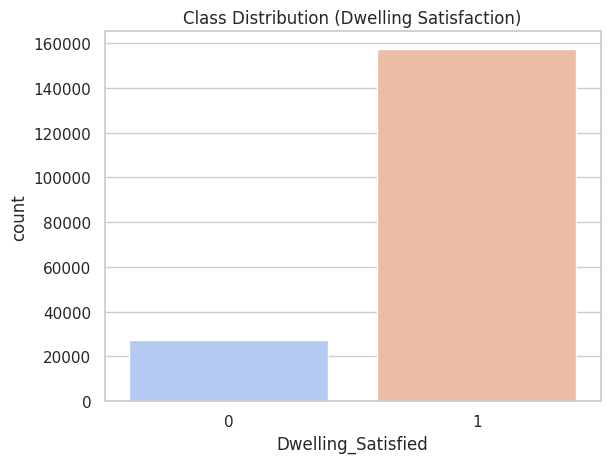

In [33]:
# Visualising a Countplot for the Target Variable Distribution

sns.countplot(x = 'Dwelling_Satisfied', data = df1, palette = 'coolwarm')
plt.title('Class Distribution (Dwelling Satisfaction)')
plt.show()

## Observaties (English: Observations)

----

#### **1) Nederlands**
- Zoals hierboven te zien is in de Geluksniveau Check, kunnen we een enorme class imbalance bevestigen.
- Vooruitkijkend kunnen we geen model bouwen dat de kleine groep van de bevolking die ontevreden is over hun woning negeert. Anders zal het model altijd een bewoner als een gelukkige huurder beschouwen.
- Als we de ontevreden populatie negeren, zal elk model leren om de meerderheidsgroep (tevreden mensen) te voorspellen en de minderheid (de ontevreden mensen) simpelweg te negeren.
- We moeten de ontevreden populatie, hoe klein ook in aantal, in overweging nemen zodat ons model correct voorspelt.

----

#### **2) English**
- As observed above in the Happiness Level Check, we can confirm a huge class imbalance.
- Moving forward, we cannot build a model ignoring the small part of the population that is unhappy with their houses. Otherwise, the model will always consider a resident as a happy tenant.
- If we ignore the unhappy population, any model will learn to predict the majority class (satisfied people) and just ignore the minority (those who are dissatisfied).
- We need to consider the unhappy population, however small in number, so that our model predicts correctly.

## **Data Preprocessing**

#### 1) Drop Columns

In [34]:
# Drop unnecessary columns and target variable

# 1) Drop 'ID' because it makes no difference to how our model works.

# 2) Drop the target variable: 'SatisfactionWithCurrentDwelling_1'.

# 3) Drop the feature 'SatisfactionWithLivingEnvironment_2' to avoid data leakage
# As it is strongly correlated with the target, and may influence our model.

# 4) Drop the feature 'Margins' as it is offering statistical summary, and not the raw individual responses.
# It does not add any predictive value.

df_model = df1.drop(columns=['ID', 'SatisfactionWithCurrentDwelling_1',
                             'SatisfactionWithLivingEnvironment_2','Margins'])

#### 2) Encode the Features

In [35]:
# Convert 'Periods' to int (ordinal)
# No use for label encoding as they have numeric meaning (years).

df_model['Periods'] = df_model['Periods'].astype(int)

# One-hot encode all nominal categorical columns

df_model = pd.get_dummies(df_model, columns = ['OwnerTenant', 'DwellingCharacteristics', 'Regions'], drop_first = True)

#### 3) Split the Features

In [36]:
# Split features and target

X = df_model.drop('Dwelling_Satisfied', axis = 1)
y = df_model['Dwelling_Satisfied']

# Train-test split with stratification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

#### 4) Scale the Data

In [37]:
# from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 5) Apply SMOTE
- Minority class in <20%.
- Target is binary (happy vs unhappy).

In [38]:
# Apply SMOTE to training data only, as test data must simulate "real, unseen data".

smote = SMOTE(random_state = 42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

## **Model Building**

#### 1) Logistic Regression

In [39]:
# from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter = 1000, random_state = 42)
logreg.fit(X_train_res, y_train_res)
y_pred_logreg = logreg.predict(X_test_scaled)

# from sklearn.metrics import classification_report

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.50      0.82      0.62      5418
           1       0.96      0.86      0.91     31490

    accuracy                           0.85     36908
   macro avg       0.73      0.84      0.76     36908
weighted avg       0.90      0.85      0.87     36908



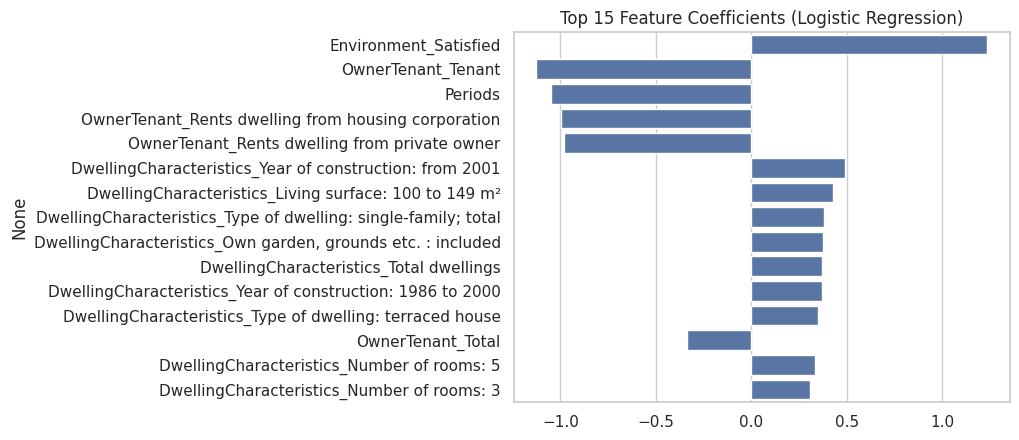

In [40]:
# Feature Importance

coef = pd.Series(logreg.coef_[0], index = X.columns)
top_coef = coef.sort_values(key = abs, ascending = False).head(15)
sns.barplot(x = top_coef.values, y = top_coef.index)
plt.title("Top 15 Feature Coefficients (Logistic Regression)")
plt.show()

## Observaties (English: Observations): Logistic Regression

----

#### **1) Nederlands**
- Nieuwere woningen met tuinen en gebouwd na 2001 verbeteren de tevredenheid aanzienlijk.
- 'Environment_Satisfied' is de sterkste positieve voorspeller van woningtevredenheid. Dit houdt in dat mensen die tevreden zijn met hun omgeving waarschijnlijk ook tevreden zijn met hun woning.
- Huren, vooral bij een woningcorporatie, correleert negatief met tevredenheid.

----

#### **2) English**
- Newer homes with gardens and built after 2001 significantly improve satisfaction.
- 'Environment_Satisfied' is the strongest positive predictor of dwelling satisfaction. This implies that people who are happy with their environment are likely also happy with their home.
- Renting, especially from a housing corporation, negatively correlates with satisfaction.

#### 2) Random Forest

In [41]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Report:
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      5418
           1       0.93      0.93      0.93     31490

    accuracy                           0.87     36908
   macro avg       0.75      0.75      0.75     36908
weighted avg       0.87      0.87      0.87     36908



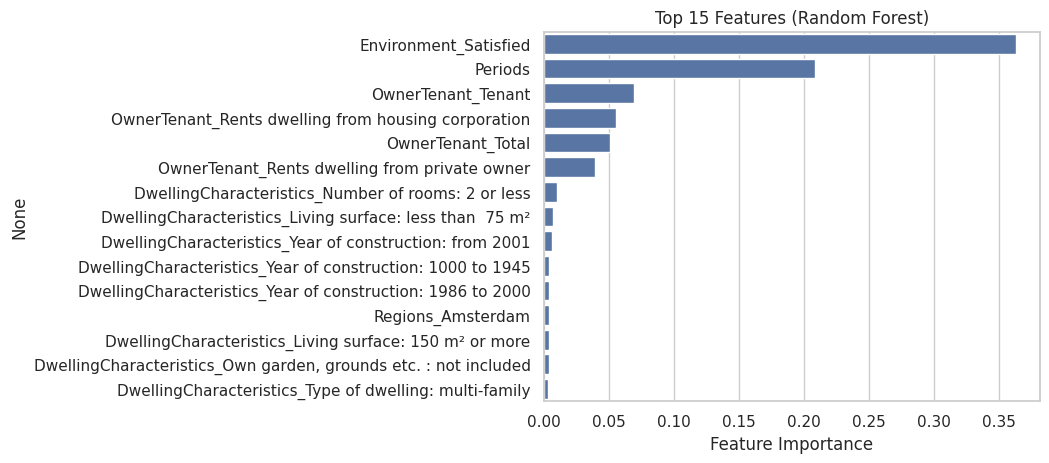

In [42]:
# Feature Importance

importances = pd.Series(rf.feature_importances_, index = X.columns)
top_importances = importances.sort_values(ascending = False).head(15)
sns.barplot(x = top_importances.values, y = top_importances.index)
plt.title("Top 15 Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.show()

## Observaties (English: Observations): Random Forest

----

#### **1) Nederlands**
- Wederom domineert 'Environment_Satisfied', zelfs meer dan in de Logistische Regressie.
- Periodes (bouwjaar), huurstatus en kleine woningkenmerken (kamers < 75m²) verminderen de tevredenheid.

----

#### **2) English**
- Again, 'Environment_Satisfied' dominates, even more than in Logistic Regression.
- Periods (construction year), tenure status, and small home features (rooms < 75m²) reduce satisfaction.

#### 3) XGBoost

In [43]:
# import xgboost as xgb

xgb_model = xgb.XGBClassifier(eval_metric = 'logloss', random_state = 42)
xgb_model.fit(X_train_res, y_train_res)

y_pred_xgb = xgb_model.predict(X_test_scaled)

print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68      5418
           1       0.94      0.96      0.95     31490

    accuracy                           0.91     36908
   macro avg       0.83      0.80      0.81     36908
weighted avg       0.91      0.91      0.91     36908



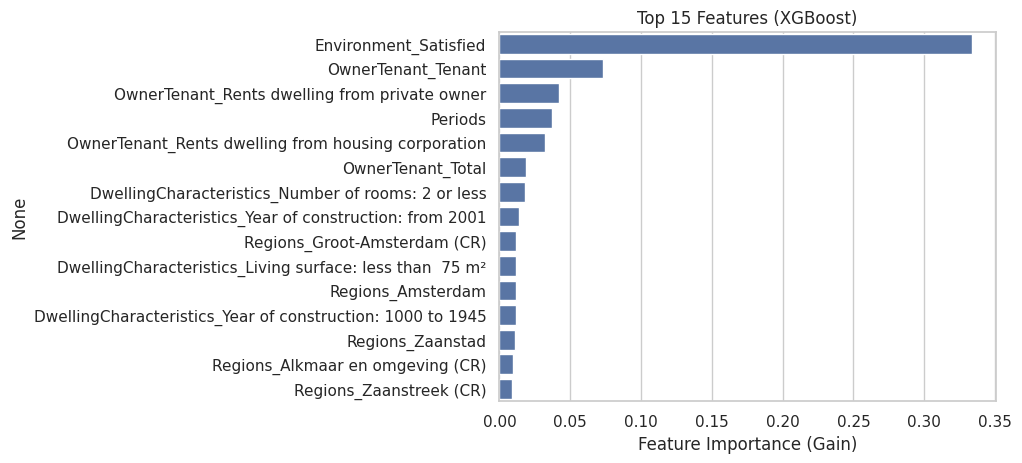

In [44]:
#### Higher gain = The feature contributes more to reducing prediction error.
#### Lower gain = The feature is less useful in decision-making during tree splits.

importances = pd.Series(xgb_model.feature_importances_, index = X.columns)

# Top 15 important features

top_importances = importances.sort_values(ascending = False).head(15)

# Plot

sns.barplot(x = top_importances.values, y = top_importances.index)
plt.title('Top 15 Features (XGBoost)')
plt.xlabel('Feature Importance (Gain)')
plt.show()

## Observaties (English: Observations): XGBoost

----

#### **1) Nederlands**
- De tevredenheid van bewoners over hun leefomgeving speelt de grootste rol bij het bepalen van de algemene woonsatisfactie. Het verbeteren van factoren op buurtniveau kan een grotere impact hebben op tevredenheid dan veranderingen aan de woning zelf.
- ensen die huren van particuliere verhuurders zijn onevenredig sterk vertegenwoordigd onder de groep met lage tevredenheid. Huurders in het algemeen (vergeleken met eigenaren) tonen een lagere woonsatisfactie, vooral bij particuliere huur.
- Bewoners van kleinere woningen (met ≤2 kamers of <75 m²) zijn doorgaans minder tevreden. Opvallend is dat nieuwere woningen, gebouwd na 2001, geassocieerd worden met hogere tevredenheid, wat wijst op een positieve waardering van de recente bouwkwaliteit of voorzieningen.
- Bewoners in en rond Amsterdam en de regio Noord-Holland vertonen meer ontevredenheid in vergelijking met andere gebieden. Dit kan wijzen op woningdruk, betaalbaarheidsproblemen of stedelijke dichtheid in deze verstedelijkte zones.

----

#### **2) English**
- Residents’ satisfaction with their living environment plays the largest role in determining overall housing satisfaction. Improving neighbourhood-level factors may have a greater impact on satisfaction than changing the dwelling itself.
- People who rent from private owners are disproportionately represented among those with low satisfaction. Tenants in general (vs. owners) show lower housing satisfaction, especially in private rentals.
- Residents in smaller dwellings (with ≤2 rooms or <75 m²) tend to be less satisfied. Interestingly, newer homes built after 2001 are associated with higher satisfaction, suggesting a positive view of recent construction quality or amenities.
- Residents in and around Amsterdam and the North Holland region tend to show more dissatisfaction compared to other areas. This could reflect housing pressures, affordability, or urban density issues in these urbanised zones.


## Modelvergelijking (English: Model Comparison)

----

#### **1) Nederlands**
- Het Logistic Regression-model levert de laagste nauwkeurigheidsscore op.
- Met slechts een lichte verbetering in nauwkeurigheid ten opzichte van het Logistic Regression-model, kost het Random Forest-model veel tijd. Het is het meest tijdrovende model.
- Het XGBoost-model levert de hoogste nauwkeurigheid op. Bovendien is het niet zo tijdsintensief als Logistic Regression.
- Daarom is XGBoost de ideale kandidaat voor hyperparameterafstemming.
----

#### **2) English**
- The Logistic model returns the lowest accuracy score.
- With only a slight improvement in accuracy from the Logistic Regression model, the Random Forest model takes a lot of time. It is the most time-consuming model.
- The XGBoost model returns the highest accuracy. Moreover, it is not time-intensive like Logistic Regression.
- Thus, the XGBoost is the perfect candidate for hyperparameter tuning.



## **Hyperparameter Tuning**

In [45]:
# Tuning the XGBoost Model

# from sklearn.model_selection import GridSearchCV

xgb_model_tuned = xgb.XGBClassifier(eval_metric = 'logloss', random_state = 42)

param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5],
              'learning_rate': [0.05, 0.1], 'subsample': [0.8, 1.0]}

grid_xgb = GridSearchCV(xgb_model_tuned, param_grid, scoring = 'f1', cv = 3)
grid_xgb.fit(X_train_res, y_train_res)

print('\nBest XGBoost Parameters:')
print(grid_xgb.best_params_)

xgb_model_tuned = grid_xgb.best_estimator_
y_pred_xgb_tuned = xgb_model_tuned.predict(X_test_scaled)

print('\nTuned XGBoost Report:')
print(classification_report(y_test, y_pred_xgb_tuned))



Best XGBoost Parameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

Tuned XGBoost Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67      5418
           1       0.94      0.95      0.94     31490

    accuracy                           0.91     36908
   macro avg       0.81      0.80      0.81     36908
weighted avg       0.90      0.91      0.90     36908



In [46]:
# Feature importance

xgb_importances = pd.Series(xgb_model_tuned.feature_importances_, index = X.columns).sort_values(ascending = False)

print('\nTop XGBoost Features:')
print(xgb_importances.head(10))


Top XGBoost Features:
Environment_Satisfied                                         0.319890
OwnerTenant_Tenant                                            0.071220
OwnerTenant_Rents dwelling from private owner                 0.047389
Periods                                                       0.044511
OwnerTenant_Rents dwelling from housing corporation           0.037364
OwnerTenant_Total                                             0.024473
DwellingCharacteristics_Number of rooms: 2 or less            0.019391
DwellingCharacteristics_Living surface: less than  75 m²      0.016624
DwellingCharacteristics_Year of construction: 1000 to 1945    0.014481
DwellingCharacteristics_Year of construction: from 2001       0.013573
dtype: float32


## XGB - Standaard versus Getunede (English: XGB - Regular vs. Tuned)

----

#### **1) Nederlands**
- Minimale winst in algehele nauwkeurigheid door hypertuning. Dit suggereert dat de standaardinstellingen van XGBoost al dicht bij optimaal lagen.
- De precisie voor klasse 0 (ontevreden bewoners) daalde licht van 0,72 naar 0,69, terwijl de recall steeg van 0,64 naar 0,65.
- Het getunede model herkent iets meer gevallen van klasse 0, maar dit gaat gepaard met iets meer fout-positieven (lagere precisie).
- Daarom is het **getunede model in een realistische situatie juist waardevol**, omdat het helpt om minder ontevreden bewoners over het hoofd te zien. En juist die mensen verdienen extra aandacht.

----

#### **2) English**
- Minimal overall accuracy gain from hypertuning. This suggests that the default XGBoost setup was already close to optimal.
- The precision for class 0 (unsatisfied residents) decreased slightly from 0.72 to 0.69, while recall increased from 0.64 to 0.65.
- The tuned model catches slightly more class 0 cases, but at the cost of slightly more false positives (lower precision).
- Therefore, the **tuned model is actually beneficial in the real-world scenario** to prevent missing out on the dissatisfied residents. Those are the people who need to be looked after.



## Inzichten en Inferenties (English: Insights and Inferences)

----

#### **1) Nederlands**
- Tevredenheid over de omgeving en woning zijn sterk gecorreleerd; het verbeteren van één van beide verhoogt de ander.
- Beleidsimplicatie: Focus op het verbeteren van sociale woningbouw beheerd door corporaties. Hier ligt de meeste ontevredenheid.
- Woningkenmerken zoals het hebben van een tuin, meer kamers en nieuwere bouwjaren zijn sterke positieve voorspellers.
- De bouwperiode (nieuwer > ouder) heeft duidelijk invloed op de tevredenheid in alle modellen.
- Huurders voelen zich minder in controle en zijn meer ontevreden dan huiseigenaren. Een nuttig inzicht voor woningautoriteiten en stadsplanning.

----

#### **2) English**
- Environment and housing satisfaction are highly correlated; improving either one boosts the other.
- Policy Implication: Focus on improving public housing managed by corporations. This is where the most dissatisfaction lies.
- Dwelling Characteristics such as having a garden, more rooms, and newer build years are strong positive predictors.
- Period of construction (newer > older) clearly impacts satisfaction across models.
- Tenants feel less in control and more dissatisfied than owners. A useful insight for housing authorities and urban planning.

## **Save the Model**

In [51]:
# from google.colab import files
# import joblib

# Save model and scaler

joblib.dump(xgb_model_tuned, 'xgboost_model_tuned.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Download scaler directly

files.download('scaler.pkl')

# Zip the model (I am zipping the model as direct download was not working for me. You may try downloading it directly.)

!zip xgb_model.zip xgboost_model_tuned.pkl

# Download the zipped model

files.download('xgb_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: xgboost_model_tuned.pkl (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Data Project Summary**

----

#### **1) Nederlands**
- Gebruikte de CBS StatLine dataset (Nederland) om woningtevredenheid te modelleren en voorspellen met behulp van logistische regressie, random forest en XGBoost.
- Behandelde class imbalance met SMOTE en evalueerde modelgelijkheid tussen huurgroepen.
- Ontdekt dat omgevingskwaliteit, eigendomstype en woningkenmerken (bijv. tuin, bouwjaar) belangrijke drijfveren zijn.
- Bood bruikbare visuele inzichten en mogelijke beleidsrichtingen voor stedelijke woningverbeteringen.

----

#### **2) English**
- Used the CBS StatLine dataset (Netherlands) to model and predict housing satisfaction using logistic regression, random forest, and XGBoost.
- Addressed class imbalance using SMOTE and evaluated model fairness across tenant groups.
- Found that environment quality, ownership type, and dwelling characteristics (e.g., garden, build year) are key drivers.
- Delivered actionable visual insights and potential policy directions for urban housing improvements.